In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from urllib.request import urlopen
words = urlopen("https://raw.githubusercontent.com/karpathy/makemore/master/names.txt").read().decode().splitlines()

In [3]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
block_size = 3 # context window
X, Y = [], []
for w in words[:2] :
    print(w)
    context = [0] * block_size
    for ch in w + '.' :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([12, 3]), torch.int64, torch.Size([12]), torch.int64)

In [8]:
# Input layer (27 lettres en 2D)
C = torch.randn((27, 2)) # 27 lettres en 2d
emb = C[X] # embedding de chaque character (de chaque truple)
# Exemple
C[X][2, 2] # L'embedding du character à la 3 lignes, 3 colonnes de X input ('m')

tensor([ 0.3413, -0.6149])

In [9]:
# 12 samples with 3 characters embedded in 2 dimensions
emb.shape

torch.Size([12, 3, 2])

In [16]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]])
# same thing as
# torch.cat(torch.unbind(emb, 1), 1).shape
# same thing as (but less efficient than)
emb.view(-1, 6).shape
#concat les thoughts vector dans la 2ème dimension de la matrice. En couple cote à cote. pour ne garder qu'une matrice à 2 dimensions.

torch.Size([12, 6])

In [24]:
# hidden layer
W1 = torch.randn((3*2, 100))
b1 = torch.randn(100)

In [26]:
# output de l'hidden layer
h = torch.tanh((emb.view(-1, 6) @ W1) + b1)
# @ -> sum du produit des lignes de la premier matrice avec la colonne de la seconde matrice.
# + -> addition [[1, 2],[3, 4]] + [1, 2] = [[2, 4], [4, 6]]
# tanh -> permet juste de réduire les valeurs extrêmes.
# En gros :
# On a -1 samples (tous les samples)
# emb = On a 6 neurones en entrée (3 lettres à deux neurones par lettres)
# W1, B1 = On a 100 neurones hidden.
# Les 6 neurones sont connectés aux 100. Chaque neuronnes h additionne la multiplication par le weight du lien puis ajoute son biais.
h.shape # [samples, 100] 100 neurones output. Mais on a plusieurs samples.

torch.Size([12, 100])

In [22]:
# Exemples of pytorch mul/add
A1 = torch.randn((2, 2))
B1 = torch.randn((2, 2))
C1 = torch.randn(2)
A1, B1, C1, A1@B1, A1@B1+C1

(tensor([[ 1.7091, -2.0440],
         [ 1.3854, -0.6735]]),
 tensor([[7.6833e-01, 1.0542e+00],
         [1.1877e-03, 2.1453e+00]]),
 tensor([-0.6145,  1.4950]),
 tensor([[ 1.3107, -2.5833],
         [ 1.0636,  0.0157]]),
 tensor([[ 0.6962, -1.0883],
         [ 0.4491,  1.5107]]))

In [27]:
# Output layer, 27 neurons
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [44]:
logits = h @ W2 + b2 # Exactement le même principe

In [45]:
logits = logits.exp() # to positive everything
logits = logits / logits.sum(1, keepdims=True)
logits[0]

tensor([8.5264e-14, 2.1392e-12, 1.4358e-06, 5.6795e-09, 9.0718e-06, 2.9792e-04,
        2.8367e-09, 7.8379e-04, 3.6352e-05, 6.1631e-03, 1.0530e-07, 3.4267e-09,
        1.7812e-06, 4.5613e-08, 5.3302e-14, 5.4738e-06, 1.3941e-08, 1.2863e-07,
        1.3415e-06, 4.5632e-09, 3.7315e-04, 4.3616e-09, 2.0360e-02, 9.7197e-01,
        3.0416e-14, 2.5119e-07, 2.9055e-08])

In [46]:
# On compare la sortie avec ce qu'on devrait avoir
logits[torch.arange(12), Y]
# On veut maximiser ces probas là

tensor([2.9792e-04, 7.3009e-08, 2.7117e-06, 2.2443e-11, 6.3105e-10, 5.4738e-06,
        3.0702e-03, 2.0140e-10, 5.8276e-09, 7.9294e-09, 2.8791e-14, 3.7718e-08])

In [47]:
logits[torch.arange(12), Y].mean()
# En fait pour ce batch, on a un score de précision de :

tensor(0.0003)

In [49]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # Number of parameters

3481

In [52]:
for p in parameters:
    p.requires_grad = True

In [51]:
# Loss :
logits = h @ W2 + b2
# logits = logits.exp()
# logits = logits / logits.sum(1, keepdims=True)
# loss = -logits[torch.arange(12), Y].log().mean()
loss = F.cross_entropy(logits, Y) # Efficient
loss

tensor(17.4321)

In [ ]:
# Full Neural Net :

In [54]:
# Ré-Init
block_size = 3 # context window
X, Y = [], []
for w in words :
    context = [0] * block_size
    for ch in w + '.' :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape # passage à tout le set

torch.Size([228146, 3])

In [61]:
# Training
for _ in range(1000):
    # minibatch de 32 (c'est moins précis mais ça train plus vite. Tous les samples ne seront peut être pas soumis par contre, et d'autres seront peut être soumis plusieurs fois)
    ix = torch.randint(0, X.shape[0], (32,))
    # Forward Pass
    emb = C[X[ix]] # (samples, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (samples, 27)
    loss = F.cross_entropy(logits, Y[ix]) # Efficient
    # Backpropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
    
print(loss.item())
#Voir vidéo pour calculer le learning rate et 10% du test set.

2.1358258724212646


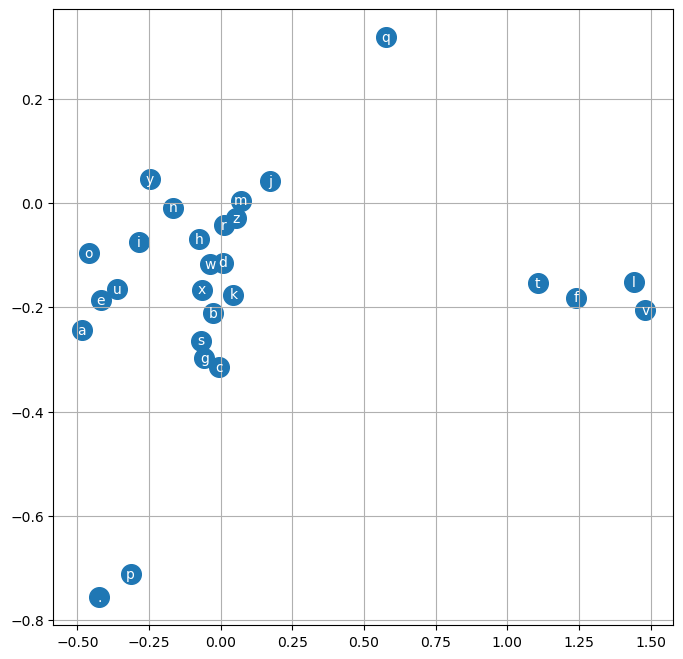

In [63]:
#Visualize embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [67]:
# Print Generate!
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        # La nouveauté est là. On selection une lettre parmi ces probas
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

juvita.
andiay.
jasalon.
kasrad.
javio.
mellzs.
saraena.
achir.
rasrii.
davle.
mellatian.
krasro.
a.
mayle.
abd.
salonalori.
asdaelarar.
ghat.
aun.
maraan.
